# **Contact Tracing System Using Machine Learning**

**Importing Necessary Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.cluster import DBSCAN

,id,timestamp,latitude,longitude
0,David,2020-07-04 15:35:30,13.148953,77.593651
1,David,2020-07-04 16:35:30,13.222397,77.652828
2,Frank,2020-07-04 14:35:30,13.236507,77.693792
3,Carol,2020-07-04 21:35:30,13.163716,77.562842
4,Ivan,2020-07-04 22:35:30,13.232095,77.580273


**Loading The Data**

In [3]:
df = pd.read_json("/cts_data.json")
df.head()

,id,timestamp,latitude,longitude
0,David,2020-07-04 15:35:30,13.148953,77.593651
1,David,2020-07-04 16:35:30,13.222397,77.652828
2,Frank,2020-07-04 14:35:30,13.236507,77.693792
3,Carol,2020-07-04 21:35:30,13.163716,77.562842
4,Ivan,2020-07-04 22:35:30,13.232095,77.580273


Creating a bounding box for plotting a geographic region based on the minimum and maximum values of longitude and latitude from the dataset

In [4]:
BBox = (df.longitude.min(),df.longitude.max(),df.latitude.min(), df.latitude.max())
BBox

(77.5533811, 77.7054541, 13.0102837, 13.2496455)

Plotting Spatial Data on Map

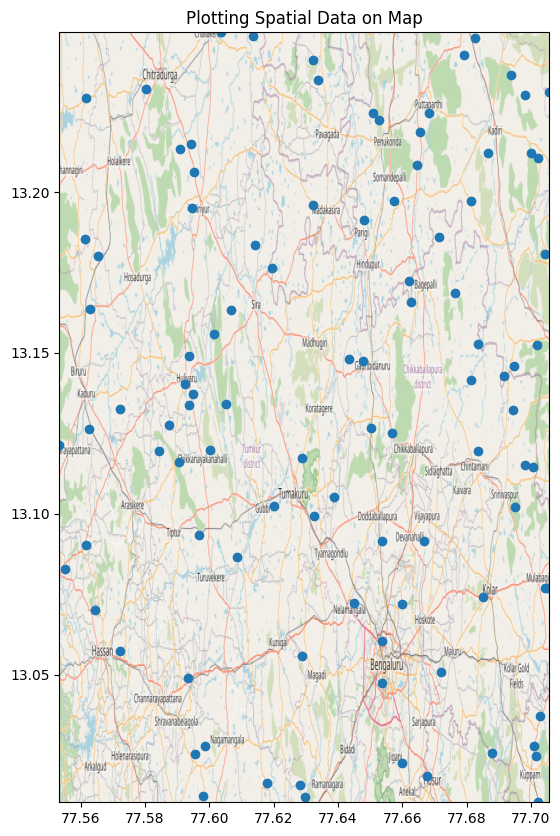

In [5]:
banglore_m = plt.imread('/cts_map.png')
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(df.longitude, df.latitude)
ax.set_title('Plotting Spatial Data on Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(banglore_m, extent = BBox, aspect= 'equal')
plt.show()

A scatter plot using Seaborn to visualize latitude vs. longitude data,with each point colored by a unique id

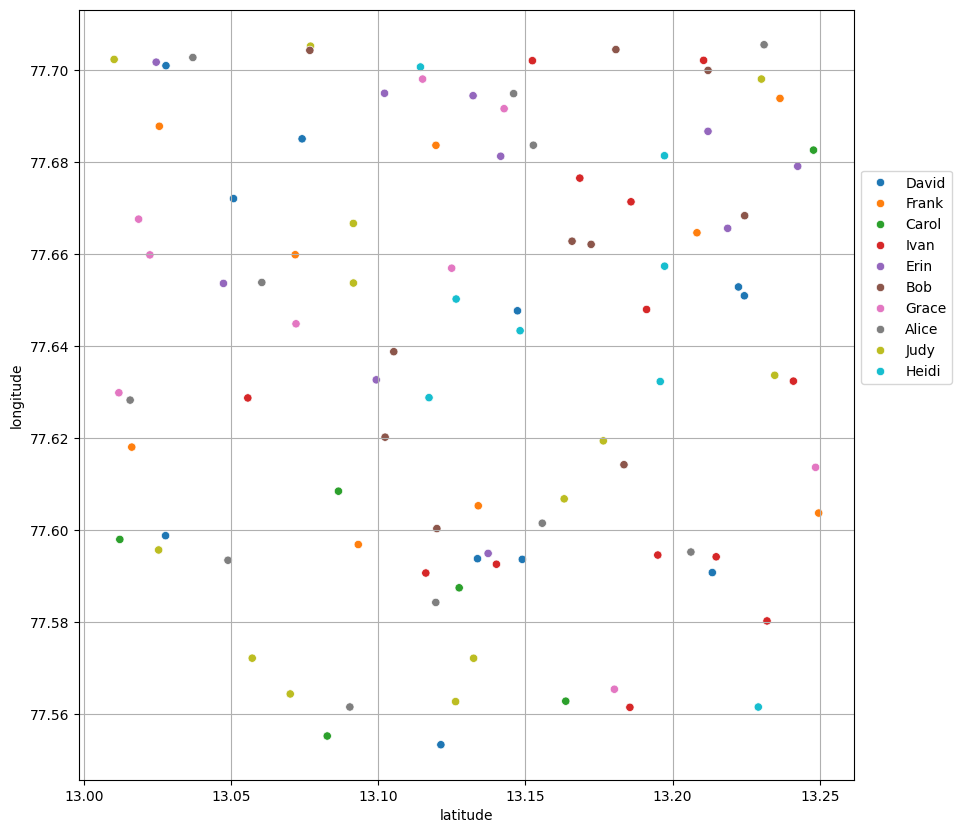

In [6]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="latitude",y="longitude",data=df,hue="id")
plt.legend(bbox_to_anchor= [1, 0.8])
plt.grid()

Visualizing one person’s path on a map

In [7]:
a=df[df.id=='Ivan']
a.head()

,id,timestamp,latitude,longitude
4,Ivan,2020-07-04 22:35:30,13.232095,77.580273
16,Ivan,2020-07-04 20:35:30,13.241058,77.632370
18,Ivan,2020-07-04 12:35:30,13.194985,77.594589
20,Ivan,2020-07-04 21:35:30,13.055701,77.628720
22,Ivan,2020-07-04 13:35:30,13.168495,77.676476


Initializing an interactive map using Folium

In [8]:
def generateBaseMap(default_location, default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         100 non-null    object        
 1   timestamp  100 non-null    datetime64[ns]
 2   latitude   100 non-null    float64       
 3   longitude  100 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 3.3+ KB


Checking Duplicate Values

In [10]:
df.duplicated().value_counts()

,count
False,100


Dropping Duplicate Values

In [11]:
df=df.drop_duplicates()

Checking Null Values

In [ ]:
df.isnull().sum()

Converting column to datetime and Creating hour column

In [12]:
df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y-%m-%d %H:%M:%S')
df['hour']=df['timestamp'].apply(lambda x: x.hour+1)
df.head()

,id,timestamp,latitude,longitude,hour
0,David,2020-07-04 15:35:30,13.148953,77.593651,16
1,David,2020-07-04 16:35:30,13.222397,77.652828,17
2,Frank,2020-07-04 14:35:30,13.236507,77.693792,15
3,Carol,2020-07-04 21:35:30,13.163716,77.562842,22
4,Ivan,2020-07-04 22:35:30,13.232095,77.580273,23


Grouping the data by hour and id to find the latest timestamp for each combination of hour and id

In [13]:
df2=pd.DataFrame(df.groupby(['hour','id'])['timestamp'].max())
df2.reset_index(inplace=True)
df2.head()

,hour,id,timestamp
0,13,Alice,2020-07-04 12:35:30
1,13,David,2020-07-04 12:35:30
2,13,Frank,2020-07-04 12:35:30
3,13,Grace,2020-07-04 12:35:30
4,13,Ivan,2020-07-04 12:35:30


Merging the two previous dataframes

In [14]:
df3=pd.merge(df2,df,left_on=['hour','id','timestamp'],right_on=['hour','id','timestamp'])
df3.head()

,hour,id,timestamp,latitude,longitude
0,13,Alice,2020-07-04 12:35:30,13.155742,77.601504
1,13,David,2020-07-04 12:35:30,13.027759,77.598796
2,13,David,2020-07-04 12:35:30,13.133737,77.593794
3,13,David,2020-07-04 12:35:30,13.074142,77.685008
4,13,Frank,2020-07-04 12:35:30,13.208293,77.664607


Creating a list of latitude and longitude pairs for each hour from 1 to 24

In [15]:
lat_long_list = []
for i in range(1,25):
    temp=[]
    for index, instance in df3[df3['hour'] == i].iterrows():
        temp.append([instance['latitude'],instance['longitude']])
    lat_long_list.append(temp)

creating a custom-sized figure (canvas) for map visualization in Folium

In [16]:
from branca.element import Figure
fig=Figure(width=550,height=350)

In [17]:
!pip install folium

 Creating an interactive heat map with time

In [18]:
import folium
from folium.plugins import HeatMapWithTime
fig7=Figure(width=850,height=550)
m7=folium.Map(location=[13.12, 77.8],zoom_start=10)
HeatMapWithTime(lat_long_list,radius=15,auto_play=True,position='bottomright').add_to(m7)
m7